<a href="https://colab.research.google.com/github/gustafarsoares23/Tech-Challenge-ML/blob/main/Tech_Challenge_2_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prevendo valores do IBOVESPA com algoritmos de machine learning**

O objetivo deste estudo é conduzir quatro tipos de testes de previsão de séries temporais!

Utilizaremos dois modelos tradicionais (média móvel e ARIMA), e também um modelo mais robusto (Prophet do Facebook - Meta)

## **Sobre o dataset**

O dataset é composto pelo histórico do valor das ações do *IBOVESPA* dentro do período de 01/01/2014 a 25/01/2024.

O Ibovespa é o principal indicador de desempenho das ações negociadas na B3 e reúne as empresas mais importantes do mercado de capitais brasileiro. Foi criado em 1968 e, ao longo desses 50 anos, consolidou-se como referência para investidores ao redor do mundo.

Reavaliado a cada quatro meses, o índice é resultado de uma carteira teórica de ativos. É composto pelas ações e units de companhias listadas na B3 que atendem aos critérios descritos na sua metodologia, correspondendo a cerca de 80% do número de negócios e do volume financeiro do nosso mercado de capitais.

Link para acessar os dados do IBOVESPA: https://br.investing.com/indices/bovespa-historical-data

### Importando as Bibliotecas

In [337]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

### Construindo o Dataset

#### Importando e checando os dados

In [338]:
# Importando a base de dados, já ajustando a coluna Data para ser o index
dados = pd.read_csv('Dados_Historicos_Ibovespa.csv', sep=",")

In [339]:
# Verificando os dados
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.01.2024,128.061,127.815,128.697,127.803,"7,54M","0,19%"
1,24.01.2024,127.816,128.275,129.446,127.680,"8,82M","-0,35%"
2,23.01.2024,128.263,126.612,128.331,126.612,"9,37M","1,31%"
3,22.01.2024,126.602,127.636,127.843,126.118,"9,51M","-0,81%"
4,19.01.2024,127.636,127.319,127.820,126.533,"11,96M","0,25%"


In [340]:
dados.tail()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
2489,08.01.2014,50.577,50.431,50.793,50.424,"2,92M","0,29%"
2490,07.01.2014,50.430,50.982,51.478,50.429,"3,34M","-1,07%"
2491,06.01.2014,50.974,50.980,51.002,50.451,"3,73M","-0,01%"
2492,03.01.2014,50.981,50.348,50.981,50.269,"7,36M","1,27%"
2493,02.01.2014,50.341,51.522,51.656,50.246,"3,48M","-2,26%"


#### Alterando o nome das colunas

In [341]:
# Renomeando as colunas para facilitar os códigos:
dados.rename(columns={'Data': 'data', 'Último': 'ultimo', 'Abertura': 'abertura', 'Máxima': 'maxima', 'Mínima': 'minima', 'Vol.': 'volume', 'Var%': 'variacao%'}, inplace=True)

In [342]:
# Verificando os dados
dados.head()

,data,ultimo,abertura,maxima,minima,volume,variacao%
0,25.01.2024,128.061,127.815,128.697,127.803,"7,54M","0,19%"
1,24.01.2024,127.816,128.275,129.446,127.680,"8,82M","-0,35%"
2,23.01.2024,128.263,126.612,128.331,126.612,"9,37M","1,31%"
3,22.01.2024,126.602,127.636,127.843,126.118,"9,51M","-0,81%"
4,19.01.2024,127.636,127.319,127.820,126.533,"11,96M","0,25%"


#### Transformando a coluna data em Datetime

In [343]:
dados['data'] = pd.to_datetime(dados['data'], format='%d.%m.%Y')

In [344]:
# Verificando os dados
dados.head()

,data,ultimo,abertura,maxima,minima,volume,variacao%
0,2024-01-25,128.061,127.815,128.697,127.803,"7,54M","0,19%"
1,2024-01-24,127.816,128.275,129.446,127.680,"8,82M","-0,35%"
2,2024-01-23,128.263,126.612,128.331,126.612,"9,37M","1,31%"
3,2024-01-22,126.602,127.636,127.843,126.118,"9,51M","-0,81%"
4,2024-01-19,127.636,127.319,127.820,126.533,"11,96M","0,25%"


#### Colocando a coluna data como index

In [345]:
dados.set_index('data', inplace=True)

In [346]:
# Verificando os dados
dados.head()

,ultimo,abertura,maxima,minima,volume,variacao%
data,,,,,,
2024-01-25,128.061,127.815,128.697,127.803,"7,54M","0,19%"
2024-01-24,127.816,128.275,129.446,127.680,"8,82M","-0,35%"
2024-01-23,128.263,126.612,128.331,126.612,"9,37M","1,31%"
2024-01-22,126.602,127.636,127.843,126.118,"9,51M","-0,81%"
2024-01-19,127.636,127.319,127.820,126.533,"11,96M","0,25%"


In [347]:
type(dados) #check para ver se realmente a coluna index

pandas.core.frame.DataFrame

#### Visualizando os valores de fechamento das ações

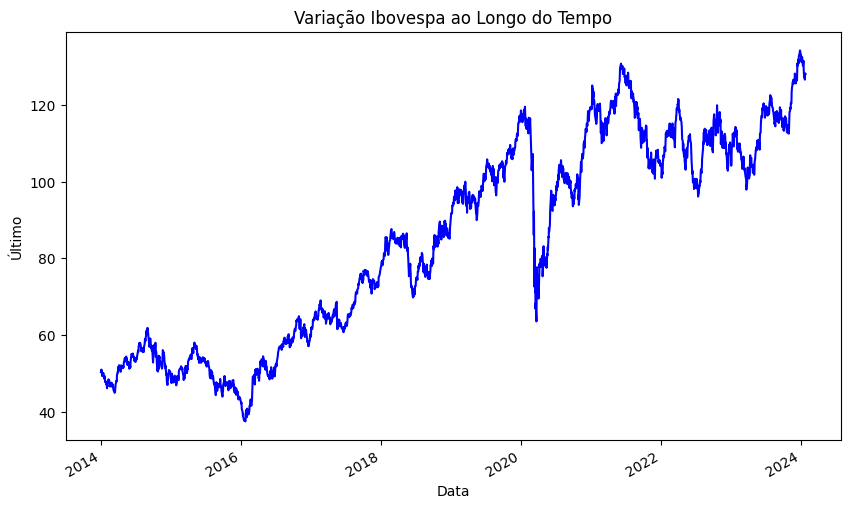

In [348]:
dados['ultimo'].plot(figsize=(10, 6), linestyle='-', color='b')

# Adicionando rótulos e título ao gráfico
plt.title('Variação Ibovespa ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Último')

# Exibindo o gráfico
plt.show()

### Criando um Dataset final

#### Excluindo colunas desnecessárias

In [349]:
df_limpo = dados.drop(['abertura', 'maxima', 'minima', 'volume', 'variacao%'], axis=1).copy()
df_limpo.index = pd.DatetimeIndex(df_limpo.index) # transformando em DatetimeIndex para usar seasonal_decompose
df_limpo.head()

,ultimo
data,
2024-01-25,128.061
2024-01-24,127.816
2024-01-23,128.263
2024-01-22,126.602
2024-01-19,127.636


In [350]:
type(df_limpo.index) # check para ver se a coluna index está como DateTimeIndex

pandas.core.indexes.datetimes.DatetimeIndex

In [351]:
df_limpo.loc['2024-01-24']

ultimo    127.816
Name: 2024-01-24 00:00:00, dtype: float64

## Decomposição para Análise da série temporal

Utilizaremos o Statsmodel para decompor a série em:

* Tendência, que é a direção da série temporal.
* Sazonalidade, que são os padrões repetidos no tempo.
* Ruído, que é a diferença entre a série original e o explicado por tendência e sazonalidade.


Importância da Decomposição:
A decomposição auxilia na compreensão dos dados e na escolha do modelo preditivo, permitindo:

* Previsões de longo prazo ao compreender a tendência.
* Previsões de curto prazo ao entender a sazonalidade.
* Melhora nos modelos ao analisar os resíduos não capturados.

Série Aditiva ou Multiplicativa:
A decomposição indica se a série é:

* Aditiva: Magnitude de sazonalidade e tendência constante.
* Multiplicativa: Magnitude varia proporcionalmente ao nível da série.

### Decompondo todo dataset em serie, tendência, sazonalidade e ruído

In [352]:
resultados = seasonal_decompose(df_limpo, model='multiplicative', period=5) # Period = sazonaliade. Como temos dados de segunda a sexta, então temos 5, referentes aos 5 dias

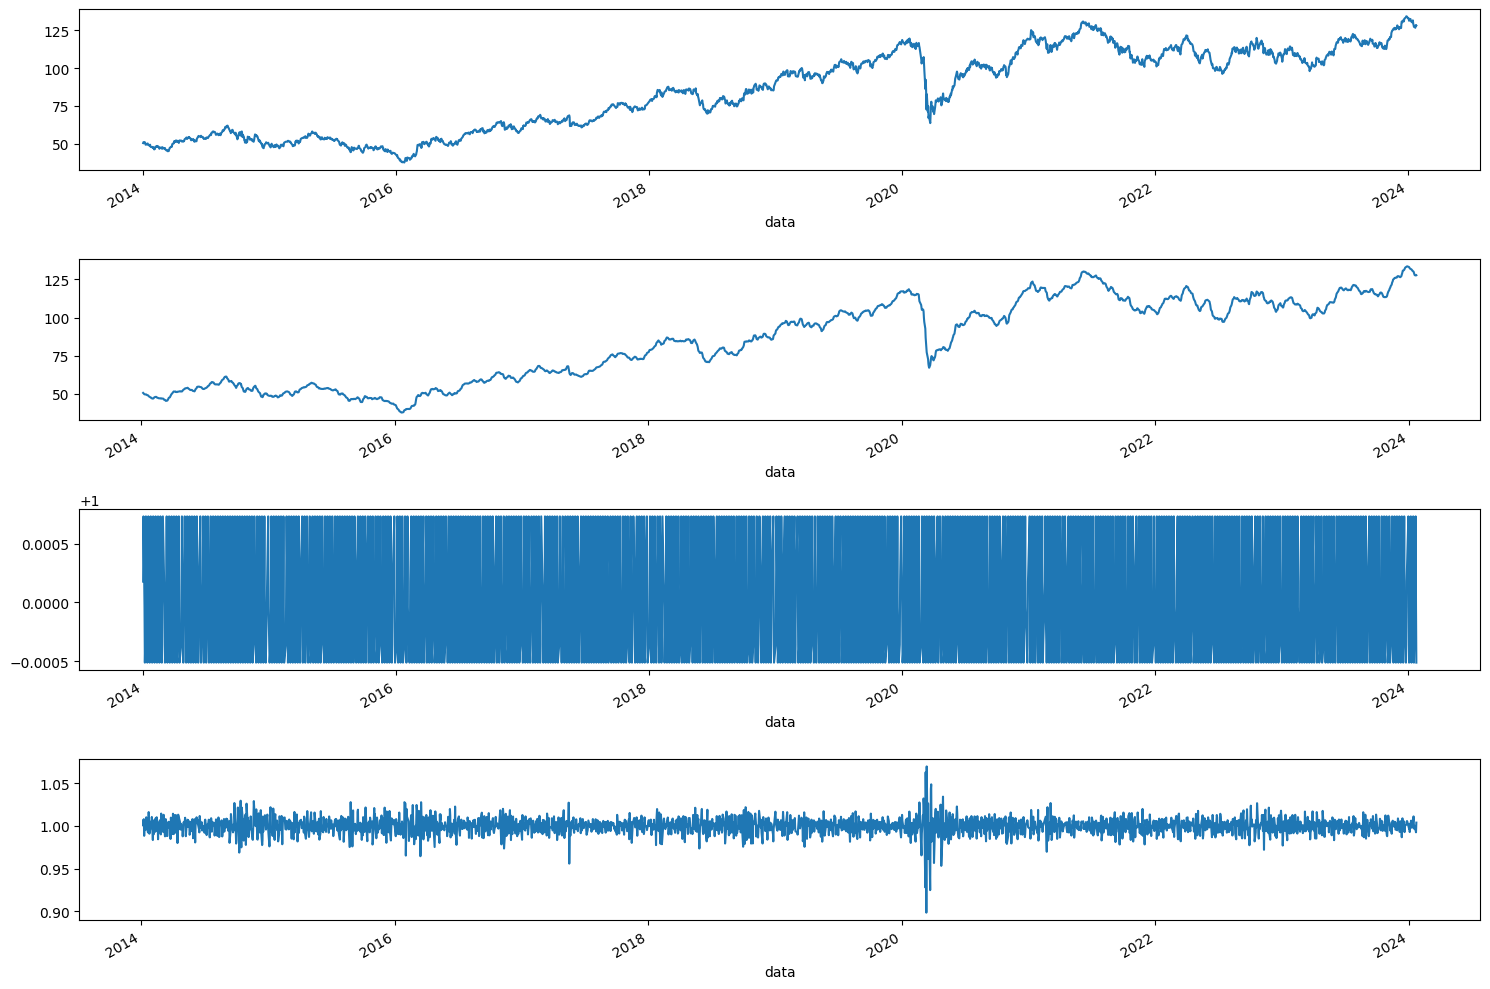

In [353]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1) # Serie dos dados
resultados.trend.plot(ax=ax2) # tendência dos dados
resultados.seasonal.plot(ax=ax3) # sazonalidade
resultados.resid.plot(ax=ax4) # resíduos

plt.tight_layout()

### Decompondo **5 anos** do dataset em serie, tendência, sazonalidade e ruído

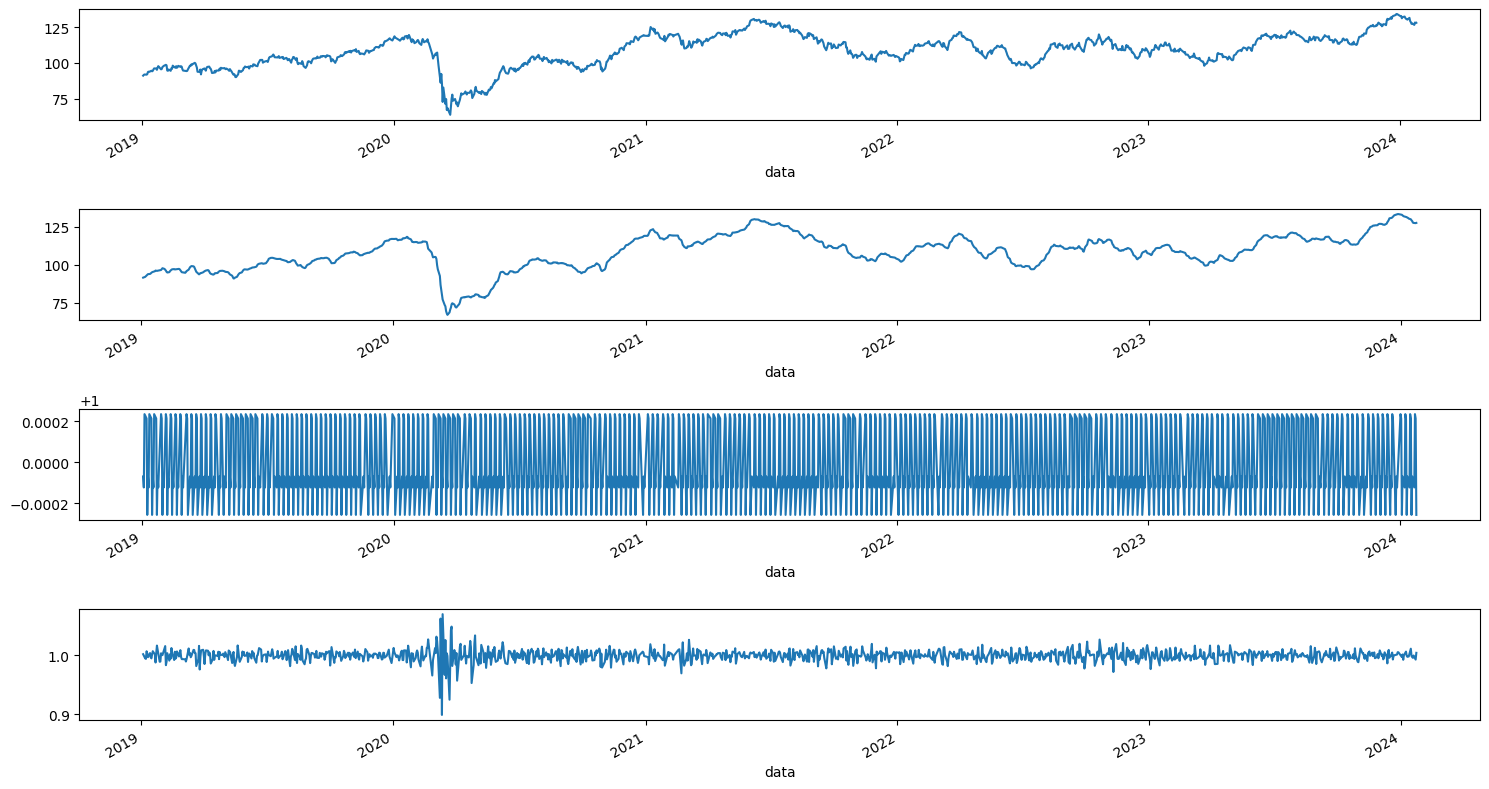

In [354]:
df_5_anos = df_limpo.loc['2019-01-01':]
seasonplot = seasonal_decompose(df_5_anos, model='multiplicative', period=5)  # decompondo a série temporal

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))
seasonplot.observed.plot(ax=ax1)  # série real
seasonplot.trend.plot(ax=ax2)  # tendência
seasonplot.seasonal.plot(ax=ax3)  # sazonalidade
seasonplot.resid.plot(ax=ax4)  # resíduos
plt.tight_layout()
plt.show()

**Ações estão subindo?**

Se notarmos a 1ª decomposição, com todos os 10 anos de dados que temos, podemos assumir, que **SIM**, as ações do IBOVESPA estão subindo ao longo dos anos.

Porém, na segunda decomposição, optei por decompor apenas os últimos 5 anos de valores do IBOVESPA, e aqui, as coisas ficam um pouco mais interessante, pois podemos perceber que o Ibovespa está com pouca variação e isso pode ser atribuído a uma combinação de fatores, incluindo:

* Diversificação do Índice: Como mencionado anteriormente, o Ibovespa é composto por ações de várias empresas de setores diferentes. Isso ajuda a suavizar as flutuações, já que eventos específicos que afetam uma empresa podem ser compensados por desempenhos positivos em outras.

* Resistência a Choques: A diversificação e a ponderação pelo valor de mercado também conferem resistência a choques. Grandes movimentos em uma única ação podem ter um impacto limitado no índice como um todo.

Logo, aqui já podemos concluir que, se fizéssemos alguns testes de estacionariedade com os últimos 5 anos, provavelmente obteríamos uma serie estacionária logo de cara. Por isso, optei por trabalhar com os últimos 10 anos dessa ação, pois sei que o IBOVESPA tende a não variar muito, pelos motivos já explicados acima, mas que ele varia sim, porém demora um pouco mais, então precisávamos de mais anos.

## **Testando Modelos de Machine Learning Clássicos**

### **Média Móvel**

A média móvel é uma técnica estatística utilizada na análise de séries temporais e dados financeiros para suavizar flutuações aleatórias e identificar tendências ao longo do tempo. A ideia básica por trás da média móvel é calcular, para cada ponto de dados em uma série temporal, a média dos pontos de dados vizinhos.

Vamos utilizar esta técnica para um N de 10 e de 20 dias.

#### Criando a base

In [355]:
df_limpo_MA = df_limpo.copy()  # criando uma cópia do DataFrame original

# Adicionando colunas ao DataFrame copiado
df_limpo_MA['MA_window_10'] = df_limpo_MA['ultimo'].rolling(10).mean().shift()  # média móvel em 10 dias
df_limpo_MA['MA_window_20'] = df_limpo_MA['ultimo'].rolling(20).mean().shift()  # média móvel em 20 dias

#Rolling = especifica o número de observações usadas para calcular a estatística
#shift = utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo

In [356]:
df_limpo_MA.head(20)

,ultimo,MA_window_10,MA_window_20
data,,,
2024-01-25,128.061,NaN,NaN
2024-01-24,127.816,NaN,NaN
2024-01-23,128.263,NaN,NaN
2024-01-22,126.602,NaN,NaN
2024-01-19,127.636,NaN,NaN
2024-01-18,127.316,NaN,NaN
2024-01-17,128.524,NaN,NaN
2024-01-16,129.294,NaN,NaN
2024-01-15,131.521,NaN,NaN


#### Vizualizando o Resultado

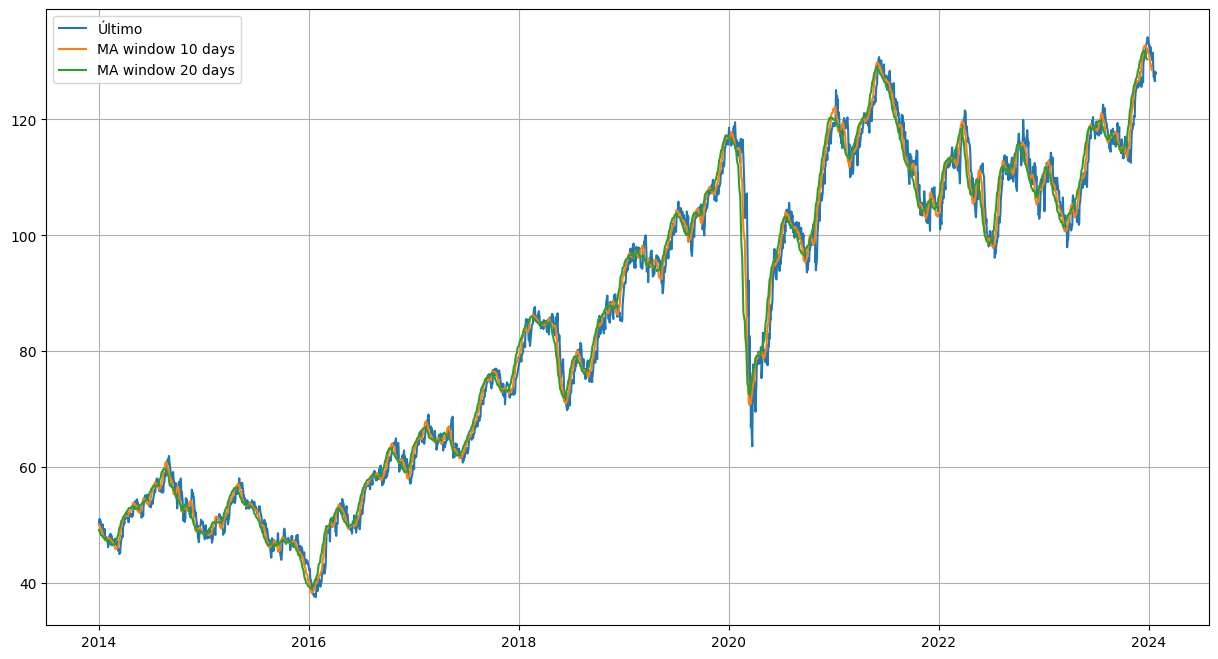

In [357]:
plt.figure(figsize=(15,8))
plt.grid(True)
plt.plot(df_limpo_MA['ultimo'], label='Último')
plt.plot(df_limpo_MA['MA_window_10'], label='MA window 10 days')
plt.plot(df_limpo_MA['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

#### Visualizando os dados mais recentes: últimos 365 dias

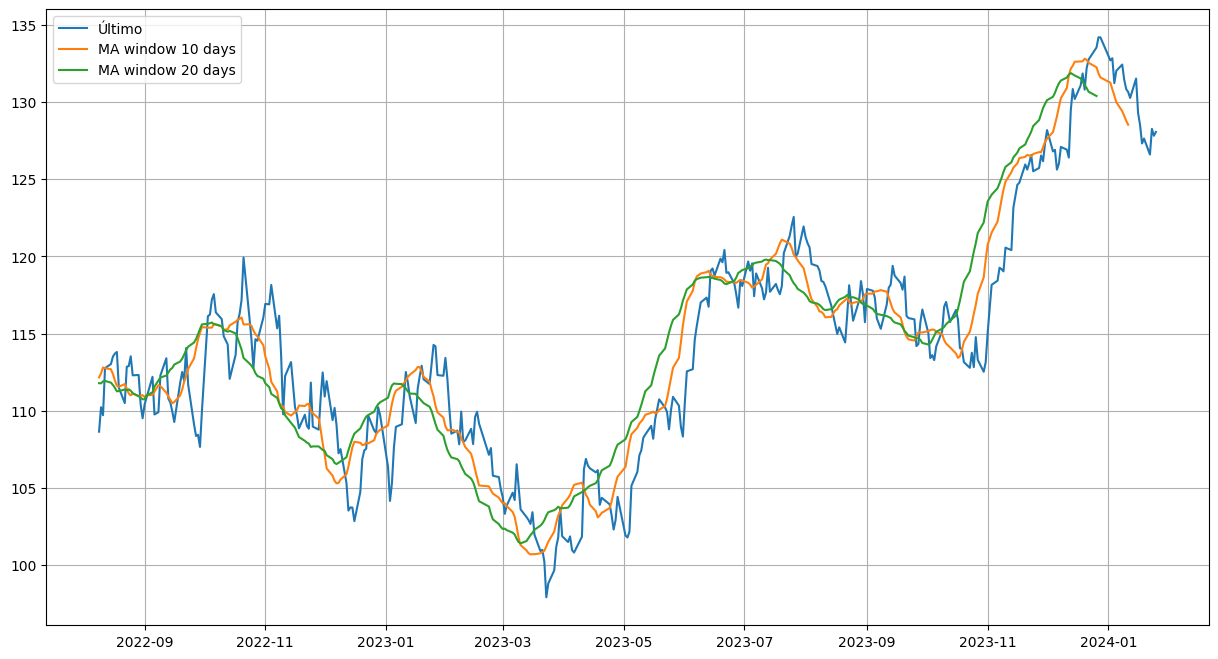

In [358]:
import matplotlib.pyplot as plt

# Ordenando o DataFrame pela coluna de datas
df_limpo_MA = df_limpo_MA.sort_index(ascending=True)

# Pegando os últimos 300 dias a partir da data mais recente
df_ultimos_300_dias = df_limpo_MA.tail(365)

plt.figure(figsize=(15, 8))
plt.grid(True)

plt.plot(df_ultimos_300_dias['ultimo'], label='Último')
plt.plot(df_ultimos_300_dias['MA_window_10'], label='MA window 10 days')
plt.plot(df_ultimos_300_dias['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

#### Prevendo os "N" dias com base na média móvel aritmética

In [359]:
df_limpo_MA['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [360]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]

In [361]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df_limpo_MA), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df_limpo_MA):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df_limpo_MA['ultimo'].iloc[window_close], df_limpo_MA['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df_limpo_MA.iat[index + i, df_limpo_MA.columns.get_loc('MA_window_10_forward_10')] = mean

#### Analisando o último ano em um gráfico, com as previsões

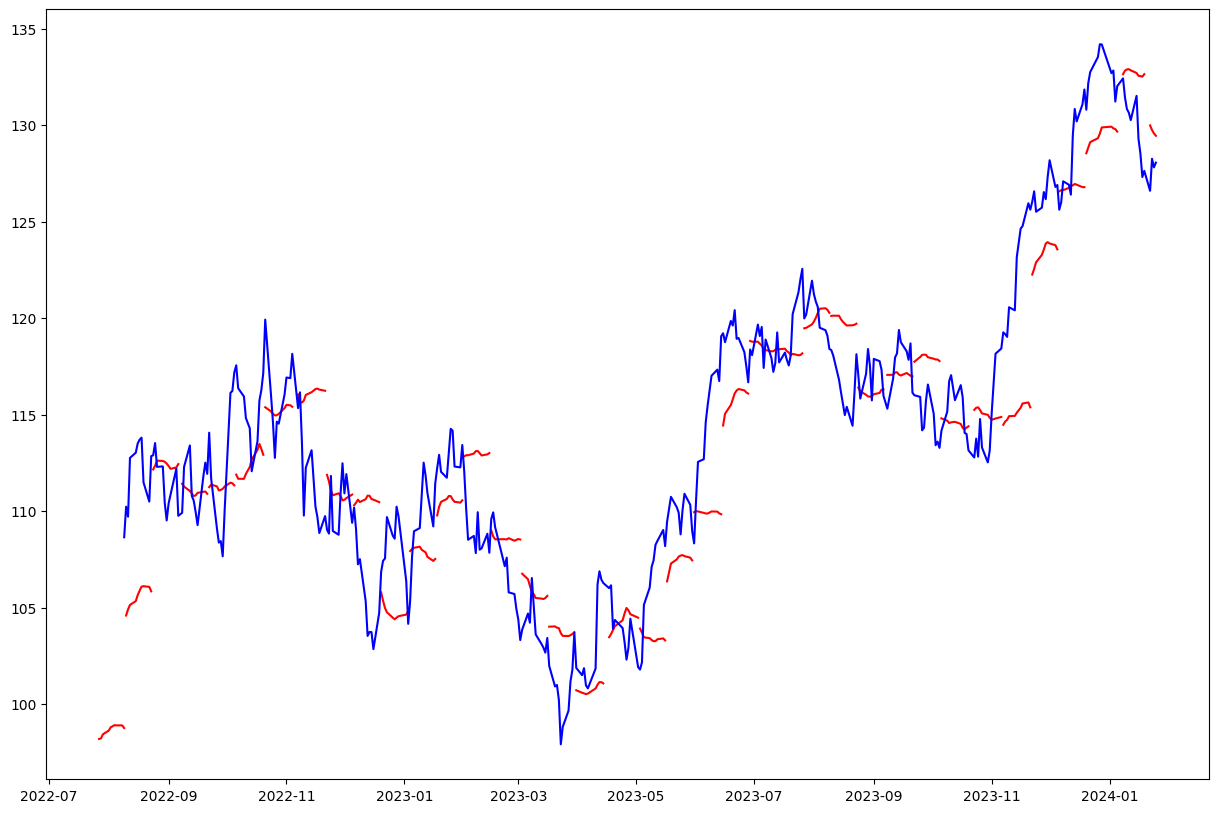

In [362]:
limit = 365

plt.figure(figsize = (15,10))

size = len(df_limpo_MA)-limit - (len(df_limpo_MA)-limit)%forward_days

for index in range(size, len(df_limpo_MA), forward_days):
    plt.plot(df_limpo_MA['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df_limpo_MA['ultimo'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Cada reta vermelha representa uma previsão de 10 dias, tomando como base os 10 dias anteriores. Por isso elas não se conectam.

Apesar de ser um modelo mais clássico, ele é bem simples, pois tem como objetivo prever N dias a frente para ver qual será o comportamento da ação.

Como vimos aqui, essa metodologia não deu certo, então vamos testar o outro Clássico, o ARIMA.

### Testando o modelo ARIMA

(Média Móvel Integrada Auto-Regressiva)

**Resumo do Texto sobre o Modelo ARIMA:**

1. **Introdução ao ARIMA:**
   - Modelo estatístico para análise e previsão de séries temporais.
   - Foco em autocorrelações nos dados, diferentemente de modelos de suavização exponencial.

2. **Componentes do Algoritmo ARIMA:**
   - Utiliza autoregressão, médias móveis e diferenciação.
   - Termos autoregressivos capturam influência de valores passados.
   - Termos de média móvel capturam erros de previsão passados.
   - Diferenciação ajuda a modelar tendências na série temporal.

3. **Estacionariedade e Diferenciação:**
   - Importância da estacionariedade para aplicação do ARIMA.
   - Série estacionária: mesma média em certos períodos; facilita projeção dos dados.
   - Discussão sobre tendência, sazonalidade e falta de padrões previsíveis em séries temporais estacionárias.

4. **Hiperparâmetros do Algoritmo ARIMA:**
   - P (lags), D (ordem de diferenciação), Q (ordem de média móvel).
   - Explicação do significado e papel de cada hiperparâmetro.

5. **Passos para Aplicar o ARIMA:**
   - Visualização dos dados da série temporal.
   - Identificação da estacionaridade.
   - Gráficos de correlação e autocorrelação.
   - Construção do modelo ARIMA com base nos dados.

6. **Análise da Correlação nos Dados:**
   - Importância de entender a autocorrelação nos modelos ARIMA.
   - Uso de funções de autocorrelação (ACF) e autocorrelação parcial (PACF).
   - Explicação sobre ACF (correlação direta e indireta) e PACF (correlação direta).


#### Plotando e analisando ACF e PCF

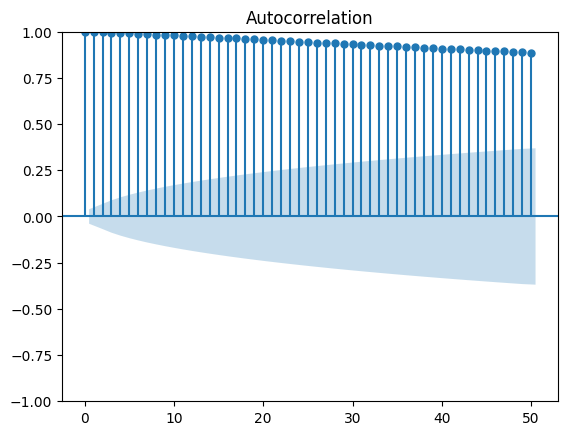

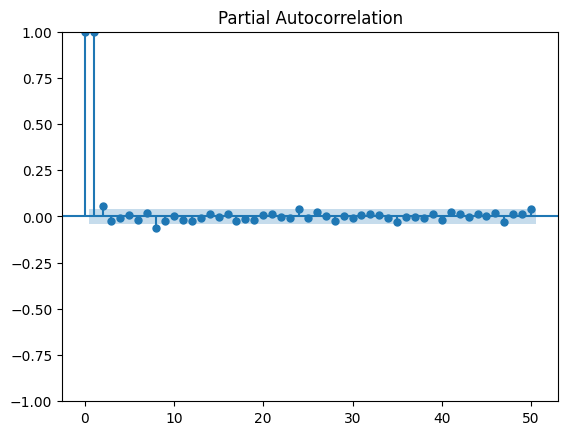

In [363]:
# Plotando a ACF
plot_acf(df_limpo['ultimo'], lags=50)

# Plotando a PACF
plot_pacf(df_limpo['ultimo'], lags=50)

plt.show()

Fazendo a análise de correlação parcial direta, os lags não contribuem significativamente para a estrutura da autocorrelação parcial após considerar os efeitos dos lags intermediários (veja os lags na área em azul).

A interpretação do PACF geralmente está relacionada à identificação do atraso específico que contribui para a autocorrelação em um determinado ponto. Ou seja, ajuda a identificar a ordem de defasagem apropriada para um modelo AR (autoregressivo). Neste caso, podemos observar que a ordem de defasagem dessa série é observada em **2 lags**.

#### Analisando e plotando média movel e desvio padrão

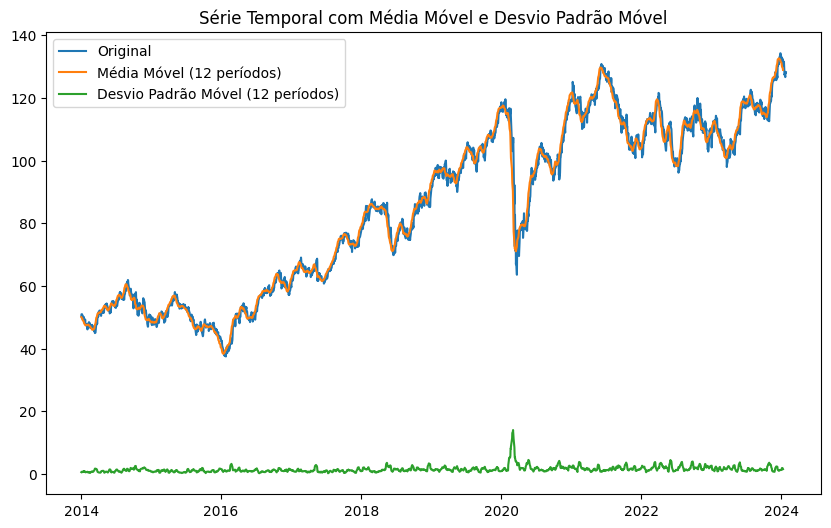

In [364]:
window_size = 12  # ajuste conforme necessário

# Calculando a média móvel e o desvio padrão
rolling_mean = df_limpo['ultimo'].rolling(window=window_size).mean()
rolling_std = df_limpo['ultimo'].rolling(window=window_size).std()

# Plotando a série temporal original, média móvel e desvio padrão
plt.figure(figsize=(10, 6))
plt.plot(df_limpo['ultimo'], label='Original')
plt.plot(rolling_mean, label=f'Média Móvel ({window_size} períodos)')
plt.plot(rolling_std, label=f'Desvio Padrão Móvel ({window_size} períodos)')

plt.title('Série Temporal com Média Móvel e Desvio Padrão Móvel')
plt.legend()
plt.show()


##### **Aplicando o Teste de Dickey-Fuller:**

1. **Teste de Dickey-Fuller:**
   - Realização do teste ADF para verificar a estacionariedade da série temporal.

2. **Estatística ADF:**
   - H0 (Hipótese Nula): A série temporal não é estacionária.
   - H1 (Hipótese Alternativa): A série temporal é estacionária.
   - Interpretação: Estatística ADF menor que valores críticos indica rejeição da hipótese nula, evidenciando estacionariedade. Quanto mais negativa, mais forte a evidência contra a hipótese nula.

3. **Valor p (p-value):**
   - Interpretação: Valor p menor que um nível de significância (por exemplo, 0.05) sugere estacionariedade na série temporal.

4. **Estacionariedade:**
   - Importância da estacionariedade para alguns modelos de séries temporais.
   - Série estacionária possui mesma média em certos períodos, facilitando a projeção dos dados.
   - Discussão sobre a falta de padrões previsíveis no longo prazo em séries temporais estacionárias.


In [365]:
# Função para realizar o Teste de Dickey-Fuller e imprimir os resultados
def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')

    print('Resultado do Teste de Dickey-Fuller:')
    print('Estatística do Teste:', result[0])
    print('Valor p:', result[1])
    print('Valores Críticos:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

    if result[1] <= 0.05:
        print("\nResultado: A série é estacionária.")
    else:
        print("\nResultado: A série não é estacionária.")

# Aplicar o Teste de Dickey-Fuller na série temporal original
adf_test(df_limpo['ultimo'].dropna())

Resultado do Teste de Dickey-Fuller:
Estatística do Teste: -1.4764166723788021
Valor p: 0.5451437523440054
Valores Críticos:
   1%: -3.4329831717881003
   5%: -2.8627033184297384
   10%: -2.5673892799386944

Resultado: A série não é estacionária.


Podemos verificar, que essa série, como já suspeitávamos, não é estacionária, pois o valor P é menor que 5 e a estatística do teste é maior que os valores críticos.

Acontece que, precisamos transformá-la em uma serie estacionária, para construir nosso modelo ARIMA, conforme próximos passos:

#### Transformando em estacionairia

In [366]:
df_limpo.head() # check para ver se nada se alterou no dataset final

,ultimo
data,
2024-01-25,128.061
2024-01-24,127.816
2024-01-23,128.263
2024-01-22,126.602
2024-01-19,127.636


##### 1º teste: subtrair os dados transformados pelo log pela média móvel.
Objetivo: Estabilizar a variância em uma série temporal, especialmente quando a amplitude dos dados varia ao longo do tempo.

Vamos utilizar o logarítmo para realizar a transformação dos dados. Nosso objetivo é remover o componente de tendência. Portanto, curvas mais planas (ou seja: paralelas ao eixo x) para séries temporais e médias contínuas após obter o log diriam que nossa transformação de dados fez um bom trabalho.

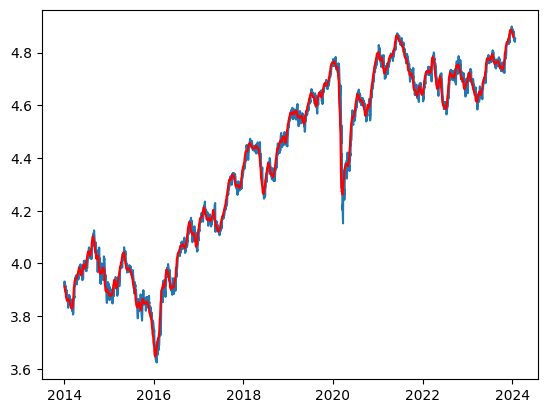

In [367]:
#Estimating trend
df_limpo_log = np.log(df_limpo) #Transformação logarítma

# Calculando a média móvel
ma = df_limpo_log.rolling(window=12).mean()
mstd = df_limpo_log.rolling(window=12).std()

# Plotando
plt.plot(df_limpo_log)
plt.plot(ma, color='red')

In [368]:
df_limpo_log_minus_ma = df_limpo_log - ma
df_limpo_log_minus_ma.head(12)

#Remove NAN values
df_limpo_log_minus_ma.dropna(inplace=True)

In [369]:
# Função para testar a estacionariedade da série transformada
def test_stationarity(timeseries):

    # Determinar estatísticas contínuas
    ma = timeseries.rolling(window=12).mean()
    mstd = timeseries.rolling(window=12).std()

    # Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(ma, color='red', label='Rolling Mean')
    std = plt.plot(mstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['ultimo'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

    # Tomar uma decisão com base no valor p
    if dfoutput['p-value'] <= 0.05:
        print("\nResultado: A série é estacionária.")
    else:
        print("\nResultado: A série não é estacionária.")


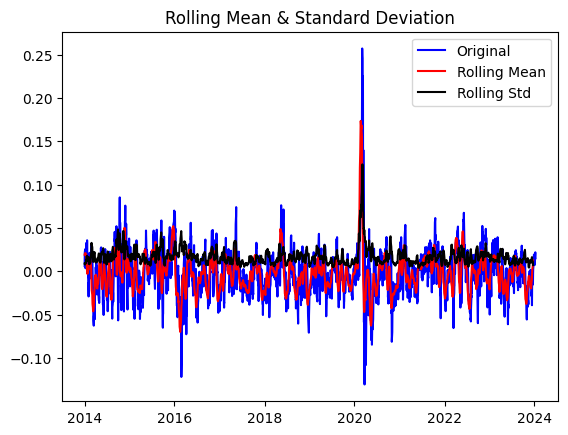

Results of Dickey Fuller Test:
Test Statistic                -1.283903e+01
p-value                        5.658976e-24
#Lags Used                     7.000000e+00
Number of Observations Used    2.475000e+03
Critical Value (1%)           -3.432995e+00
Critical Value (5%)           -2.862708e+00
Critical Value (10%)          -2.567392e+00
dtype: float64

Resultado: A série é estacionária.


In [370]:
test_stationarity(df_limpo_log_minus_ma)

Aqui já conseguimos transformar a serie em estacionária, mas vamos testar outros recursos, para torná-la mais estacionária ainda:

##### 2º teste : Decaimento exponencial.
Objetivo: Remover a tendência de uma série temporal. A ideia básica é aplicar uma média exponencial ponderada aos dados, atribuindo mais peso às observações mais recentes e menos peso às observações mais antigas.

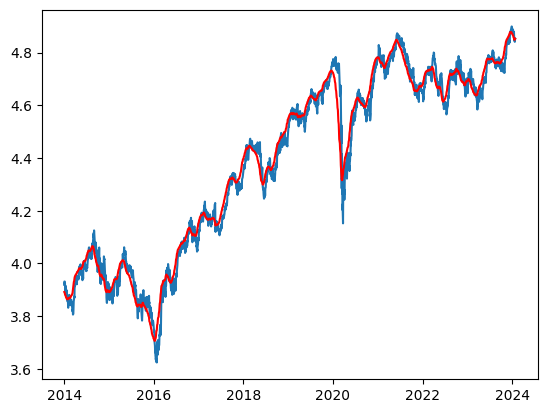

In [371]:
df_limpo_log_exponential_decay = df_limpo_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(df_limpo_log)
plt.plot(df_limpo_log_exponential_decay, color='red')

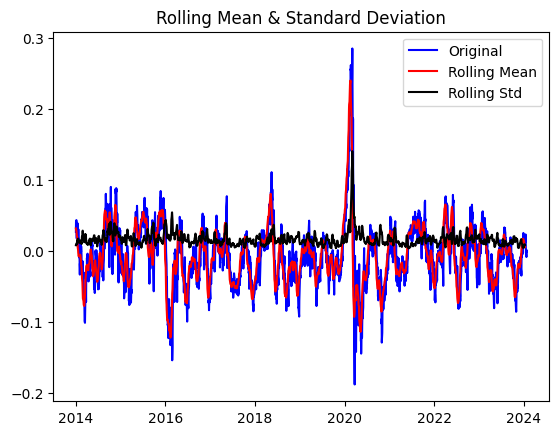

Results of Dickey Fuller Test:
Test Statistic                -7.517020e+00
p-value                        3.879076e-11
#Lags Used                     7.000000e+00
Number of Observations Used    2.486000e+03
Critical Value (1%)           -3.432983e+00
Critical Value (5%)           -2.862703e+00
Critical Value (10%)          -2.567389e+00
dtype: float64

Resultado: A série é estacionária.


In [372]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
df_limpo_log_minus_df_limpo_log_exponential_decay = df_limpo_log - df_limpo_log_exponential_decay
test_stationarity(df_limpo_log_minus_df_limpo_log_exponential_decay)

Não iremos utilizar o decaimento exponencial, pois ficou menos estacionário que subtrair os dados transformados pelo log pela média móvel. Mas ainda há um teste a ser feito:

##### 3º teste : Diferenciação
Objetivo: Remover a tendência e tornar a série mais estacionária.

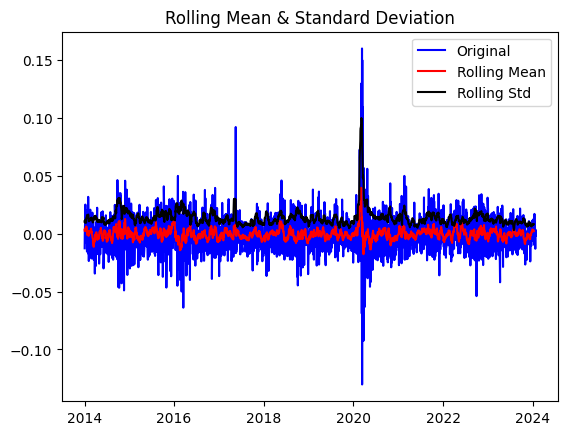

Results of Dickey Fuller Test:
Test Statistic                -1.807038e+01
p-value                        2.605238e-30
#Lags Used                     6.000000e+00
Number of Observations Used    2.486000e+03
Critical Value (1%)           -3.432983e+00
Critical Value (5%)           -2.862703e+00
Critical Value (10%)          -2.567389e+00
dtype: float64

Resultado: A série é estacionária.


In [373]:
df_limpo_log_minus_DiffShifting = df_limpo_log - df_limpo_log.shift() #diferença entre o valor anterior e o atual
df_limpo_log_minus_DiffShifting.dropna(inplace=True)
test_stationarity(df_limpo_log_minus_DiffShifting)

Parece que o Rolling Mean e Rolling STD se aproximaram mais na diferenciação. Vamos continuar com essa metodologia de diferenciação para construir nosso modelo ARIMA:

#### Teste de correlação parcial
Como definimos numa primeira tentativa o parâmetro P (lags: valores auto correlacionados) e o parâmetro Q (tamanho de uma janela) do ARIMA?

Vamos fazer isso com os gráfico de ACF (para ‘q’) e o gráfico de PACF (para ‘p’). Vamos selecionar como teste a base de dados da diferenciação.

Vamos encontrar em qual ponto cada gráfico passa em zero e este ponto será o valor de P e Q inicial (talvez em alguns casos pequenas alterações nos parâmetros do ARIMA possam melhorar/piorar os resultados, vale a pena alterar um pouco os valores um pouco positivamente e negativamente para olhar o desempenho).

Aplicando os plots ao nosso dataset de entrada (lags é o número de amostras):

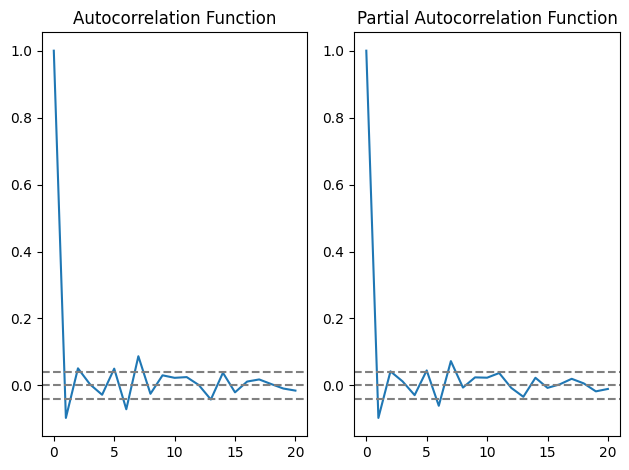

In [374]:
lag_acf = acf(df_limpo_log_minus_DiffShifting, nlags=20)
lag_pacf = pacf(df_limpo_log_minus_DiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_limpo_log_minus_DiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

A partir do gráfico ACF, vemos que a curva toca a linha y=0,0 em x=2 (Q = 2);

Do gráfico PACF, vemos que a curva toca a linha y=0,0 em x=2 (P = 2).



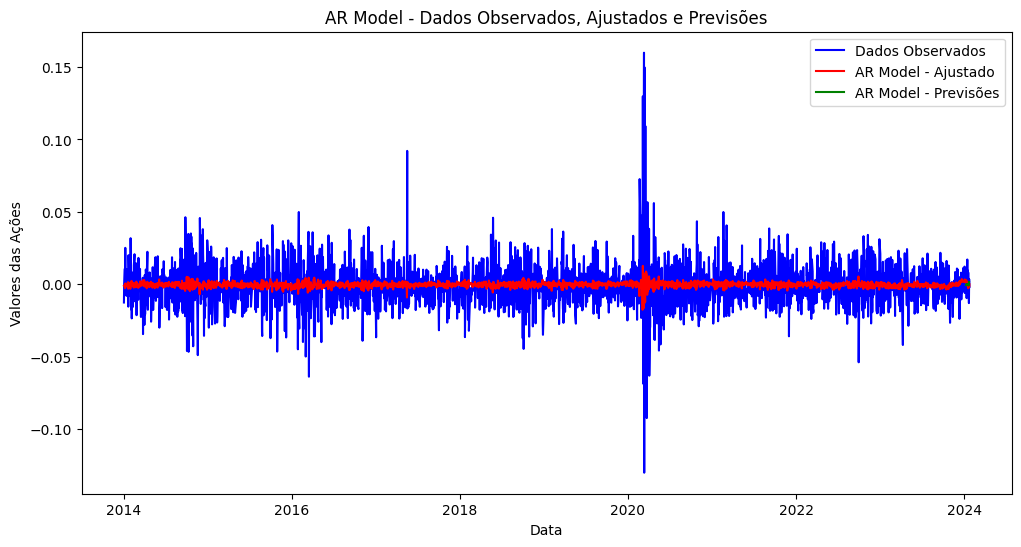

In [375]:
import warnings
warnings.filterwarnings("ignore")
# Configuração do modelo ARIMA
p = 2
d = 1
q = 2

# Ajuste do modelo ARIMA
model = ARIMA(df_limpo_log_minus_DiffShifting['ultimo'], order=(p, d, q))
results_AR = model.fit()

# Previsões
forecast_steps = 10  # Ajuste conforme necessário
forecast = results_AR.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_limpo_log_minus_DiffShifting.index.max(), periods=forecast_steps + 1, freq=df_limpo_log_minus_DiffShifting.index.to_series().diff().mean())
# Aqui, o código define o número de passos futuros para prever (forecast_steps). O modelo ajustado é então usado para obter previsões (get_forecast) para os próximos passos especificados. O índice das previsões é gerado para refletir as datas futuras.

# Plotagem dos resultados
plt.figure(figsize=(12, 6))
plt.plot(df_limpo_log_minus_DiffShifting.index, df_limpo_log_minus_DiffShifting['ultimo'], color="blue", label='Dados Observados')
plt.plot(df_limpo_log_minus_DiffShifting.index, results_AR.fittedvalues, color='red', label='AR Model - Ajustado')
plt.plot(forecast_index[1:], forecast.predicted_mean, color='green', label='AR Model - Previsões')
plt.title('AR Model - Dados Observados, Ajustados e Previsões')
plt.xlabel('Data')
plt.ylabel('Valores das Ações')
plt.legend()
plt.show()
# Aqui, os resultados são plotados. Os dados observados são mostrados em azul,
# as previsões ajustadas pelo modelo ARIMA são mostradas em vermelho e as previsões
# futuras são mostradas em verde. O gráfico visualiza como o modelo ARIMA se ajusta aos dados históricos e faz previsões para o futuro.

#### Validando o modelo com MAPE (Mean Absolute Percentage Error)

In [376]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = df_limpo_log_minus_DiffShifting.index

# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = df_limpo_log_minus_DiffShifting['ultimo'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(df_limpo_log_minus_DiffShifting['ultimo'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 50.49%


O modelo MAPE é uma métrica para valiar a precisão de previsões em séries temporais (perspectiva percentual dos erros). Quanto menor, melhor.

Nesse caso, em algumas construções do arima, estava dando 400 a 550%, mas nessa construção, consegui atingir os MAPE: 50.49%.

Se comparado as outras construções., essa não está ruim, mas de modo geral ainda está um MAPE alto, e isso geralmente indica que as previsões do modelo estão muito distantes dos valores reais.

## Testando com um modelo Robusto (Prophet)

O Prophet é uma biblioteca de código aberto desenvolvida pelo Facebook para previsão de séries temporais. Sua abordagem se baseia em uma decomposição sazonal aditiva, dividindo os dados em componentes de tendência, sazonalidade anual e efeitos de feriados. Isso permite modelar padrões temporais de maneira intuitiva.

O modelo é projetado para lidar com dados que podem conter lacunas ou irregularidades, sendo capaz de adaptar-se a diferentes tipos de padrões temporais. Além disso, o Prophet oferece a flexibilidade de incorporar informações adicionais, como feriados específicos, para melhorar as previsões. Com uma interface amigável e parâmetros ajustáveis, é acessível mesmo para usuários sem conhecimento avançado em aprendizado de máquina.

Essa abordagem torna o Prophet eficaz em várias aplicações, desde previsão de demanda até análise financeira e climatológica.

### Criando e Ajustando um novo dataset para o Prophet

In [377]:
# Use a função download para obter os dados
df = df_limpo.copy()
df['ds'] = df.index
df['y'] = df['ultimo']
df = df[['ds', 'y']].reset_index(drop=True)
df.head()

,ds,y
0,2024-01-25,128.061
1,2024-01-24,127.816
2,2024-01-23,128.263
3,2024-01-22,126.602
4,2024-01-19,127.636


Uma das características mais úteis do Prophet é sua capacidade de decompor automaticamente uma série temporal em seus componentes. Isso inclui a tendência geral, sazonalidade anual e efeitos de feriados (se fornecidos).

Com base nisso e também, sabendo que o IBOVESPA não abre em feriados Nacionais Brasileiros, criaremos uma lista de feriados de 2014 a 2024, para inserir no Prophet

### Criando lista de feriados nacionais brasileiros

In [378]:
# Lista completa de feriados
feriados_brasil = pd.DataFrame({
    'holiday': 'feriado_brasil',
    'ds': pd.to_datetime([
        '2014-01-01', '2014-03-03', '2014-03-04', '2014-04-18', '2014-04-21', '2014-05-01', '2014-06-19', '2014-09-07', '2014-10-12', '2014-11-02', '2014-11-15', '2014-12-25',
        '2015-01-01', '2015-02-16', '2015-02-17', '2015-04-03', '2015-04-21', '2015-05-01', '2015-06-04', '2015-09-07', '2015-10-12', '2015-11-02', '2015-11-15', '2015-12-25',
        '2016-01-01', '2016-02-08', '2016-02-09', '2016-03-25', '2016-04-21', '2016-05-01', '2016-05-26', '2016-09-07', '2016-10-12', '2016-11-02', '2016-11-15', '2016-12-25',
        '2017-01-01', '2017-02-27', '2017-02-28', '2017-04-14', '2017-04-21', '2017-05-01', '2017-06-15', '2017-09-07', '2017-10-12', '2017-11-02', '2017-11-15', '2017-12-25',
        '2018-01-01', '2018-02-12', '2018-02-13', '2018-03-30', '2018-04-21', '2018-05-01', '2018-05-31', '2018-09-07', '2018-10-12', '2018-11-02', '2018-11-15', '2018-12-25',
        '2019-01-01', '2019-03-04', '2019-03-05', '2019-04-19', '2019-04-21', '2019-05-01', '2019-06-20', '2019-09-07', '2019-10-12', '2019-11-02', '2019-11-15', '2019-12-25',
        '2020-01-01', '2020-02-24', '2020-02-25', '2020-04-10', '2020-04-21', '2020-05-01', '2020-06-11', '2020-09-07', '2020-10-12', '2020-11-02', '2020-11-15', '2020-12-25',
        '2021-01-01', '2021-02-15', '2021-02-16', '2021-04-02', '2021-04-21', '2021-05-01', '2021-06-03', '2021-09-07', '2021-10-12', '2021-11-02', '2021-11-15', '2021-12-25',
        '2022-01-01', '2022-02-28', '2022-03-01', '2022-04-15', '2022-04-21', '2022-05-01', '2022-06-16', '2022-09-07', '2022-10-12', '2022-11-02', '2022-11-15', '2022-12-25',
        '2023-01-01', '2023-02-20', '2023-02-21', '2023-04-07', '2023-04-21', '2023-05-01', '2023-06-08', '2023-09-07', '2023-10-12', '2023-11-02', '2023-11-15', '2023-12-25',
        '2024-01-01', '2024-02-12', '2024-02-13', '2024-03-29', '2024-04-21', '2024-05-01', '2024-05-30', '2024-09-07', '2024-10-12', '2024-11-02', '2024-11-15', '2024-11-20', '2024-12-25'
    ])
})

### Separando os dados em treino e teste

In [379]:
train_data = df.sample(frac=0.7, random_state=18)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1746, 2)
testing data size : (748, 2)


### Criando e plotando o modelo preditivo

In [380]:
modelo = Prophet(daily_seasonality=True, holidays=feriados_brasil)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/1ujxq33e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/23hc56kv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95418', 'data', 'file=/tmp/tmp0tzhhzdd/1ujxq33e.json', 'init=/tmp/tmp0tzhhzdd/23hc56kv.json', 'output', 'file=/tmp/tmp0tzhhzdd/prophet_modelt700ysia/prophet_model-20240128153428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-03,50.163596,44.194681,58.657875,50.163596,50.163596,0.863777,0.863777,0.863777,-1.26889,...,0.018316,0.018316,0.018316,2.114351,2.114351,2.114351,0.0,0.0,0.0,51.027373
1,2014-01-06,50.237565,43.040926,58.871183,50.237565,50.237565,1.154991,1.154991,1.154991,-1.26889,...,0.038732,0.038732,0.038732,2.385149,2.385149,2.385149,0.0,0.0,0.0,51.392556
2,2014-01-08,50.286877,43.679044,59.390295,50.286877,50.286877,1.202210,1.202210,1.202210,-1.26889,...,-0.097093,-0.097093,-0.097093,2.568193,2.568193,2.568193,0.0,0.0,0.0,51.489087
3,2014-01-09,50.311533,44.340558,58.901293,50.311533,50.311533,1.089699,1.089699,1.089699,-1.26889,...,-0.298584,-0.298584,-0.298584,2.657174,2.657174,2.657174,0.0,0.0,0.0,51.401233
4,2014-01-10,50.336190,45.052931,59.272093,50.336190,50.336190,1.492445,1.492445,1.492445,-1.26889,...,0.018316,0.018316,0.018316,2.743019,2.743019,2.743019,0.0,0.0,0.0,51.828635


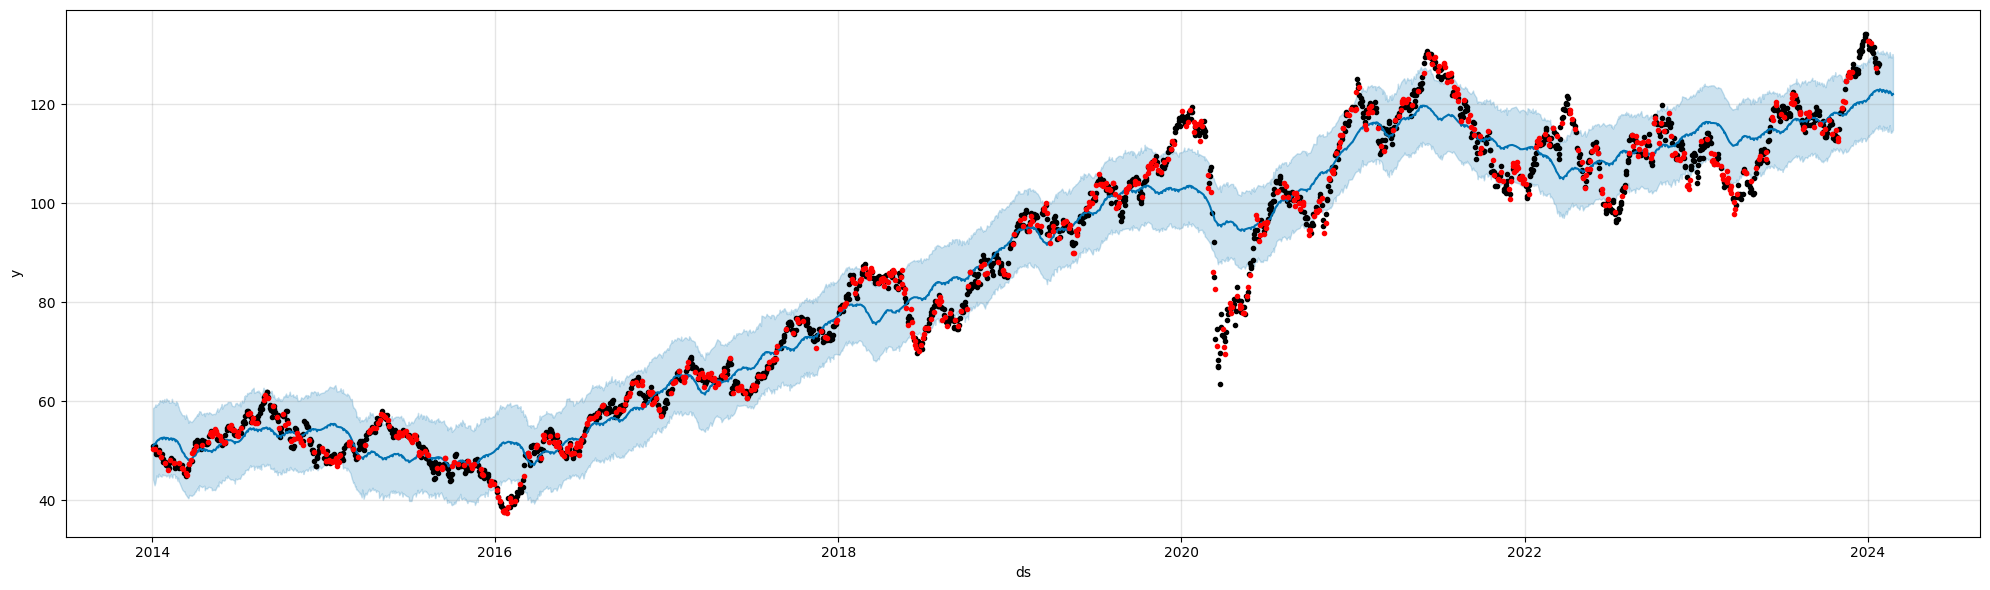

In [381]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

### Plotando com ploty

obs:como o github não renderiza javascript, estou colocando abaixo do código, um print do gráfico de ploty

In [382]:
import plotly.graph_objects as go

# Criar uma figura para o gráfico
fig = go.Figure()

# Adicionar a série temporal prevista ao gráfico
fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['yhat'], mode='lines', name='Previsão'))

# Adicionar os pontos de teste ao gráfico
fig.add_trace(go.Scatter(x=test_data['ds'], y=test_data['y'], mode='markers', marker=dict(color='red'), name='Dados de Teste'))

# Layout do gráfico
fig.update_layout(title='Previsão do Modelo',
                  xaxis_title='Data',
                  yaxis_title='Valor',
                  showlegend=True,
                  xaxis=dict(rangeslider=dict(visible=True), type='date'))

# Exibir o gráfico
fig.show()

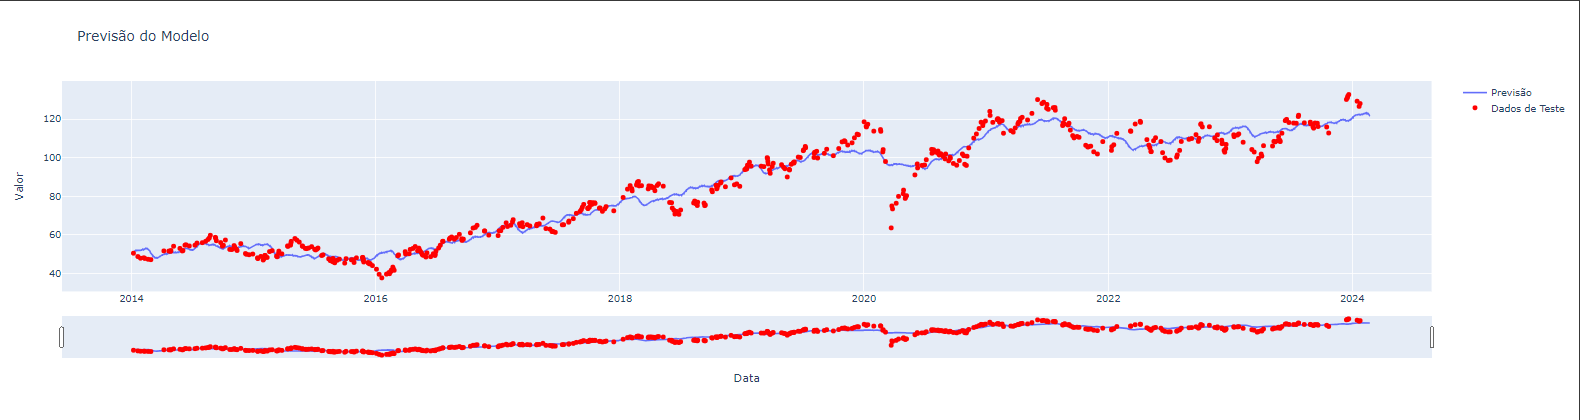

### Decompondo os dados:

Observe como o Prophet decompõe automaticamente uma série temporal em: tendência geral, feriados, e diferentes sazonalidades.

* Caso não tivéssemos adicionado a lista de feriados, ele não aparereceria aqui. Mas observe que como adicionamos, ele retornou valor zero para todos os feriados. Isso comprova que, o IBOVESPA realmente não funciona em feriados:

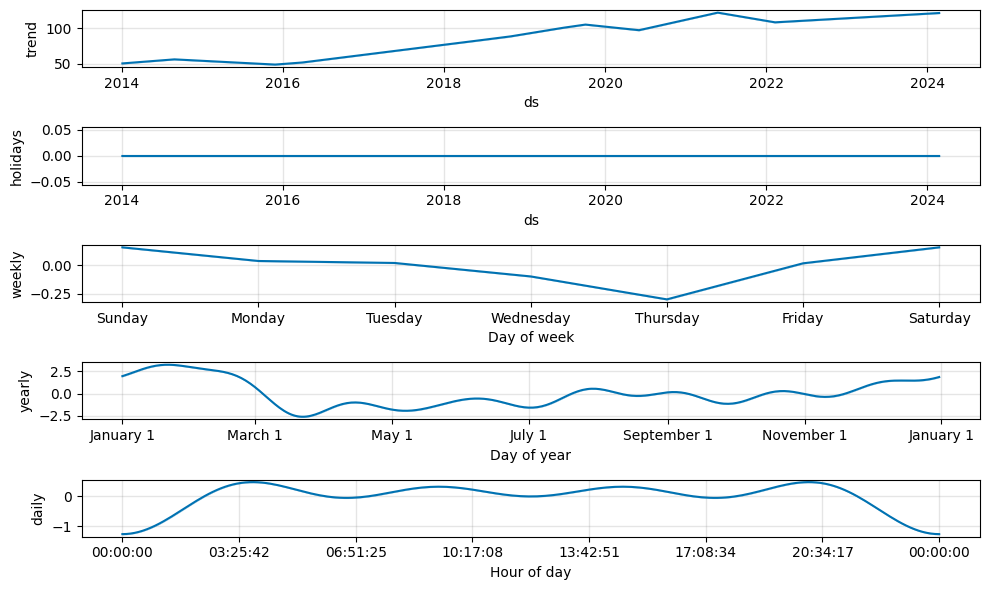

In [383]:
modelo.plot_components(previsao, figsize=(10,6));

### Adicionando Changepoints no modelo

O prophet permite adicionar pontos de mudanças na série temporal, o que nos permite identificar em quais datas ocorrem possíveis mudanças.

In [384]:
from prophet.plot import add_changepoints_to_plot

modelo_changepoints = Prophet(n_changepoints=5)
modelo_changepoints.fit(train_data)
dataFramefuture = modelo_changepoints.make_future_dataframe(periods=30, freq='D')
previsao_changepoints = modelo_changepoints.predict(dataFramefuture)
previsao_changepoints.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/zu3v6ojk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/_35qtf3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8066', 'data', 'file=/tmp/tmp0tzhhzdd/zu3v6ojk.json', 'init=/tmp/tmp0tzhhzdd/_35qtf3a.json', 'output', 'file=/tmp/tmp0tzhhzdd/prophet_modeluv4v6l_j/prophet_model-20240128153432.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
15:34:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during p

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-03,29.818712,45.661502,65.557610,29.818712,29.818712,25.542406,25.542406,25.542406,23.945585,23.945585,23.945585,1.596821,1.596821,1.596821,0.0,0.0,0.0,55.361118
1,2014-01-06,29.787091,45.341690,65.481152,29.787091,29.787091,25.790729,25.790729,25.790729,23.996511,23.996511,23.996511,1.794219,1.794219,1.794219,0.0,0.0,0.0,55.577821
2,2014-01-08,29.766011,45.407281,65.316082,29.766011,29.766011,25.615680,25.615680,25.615680,23.659169,23.659169,23.659169,1.956511,1.956511,1.956511,0.0,0.0,0.0,55.381691
3,2014-01-09,29.755471,45.978398,65.678873,29.755471,29.755471,25.635950,25.635950,25.635950,23.592822,23.592822,23.592822,2.043128,2.043128,2.043128,0.0,0.0,0.0,55.391421
4,2014-01-10,29.744930,46.432958,65.941648,29.744930,29.744930,26.077001,26.077001,26.077001,23.945585,23.945585,23.945585,2.131415,2.131415,2.131415,0.0,0.0,0.0,55.821931


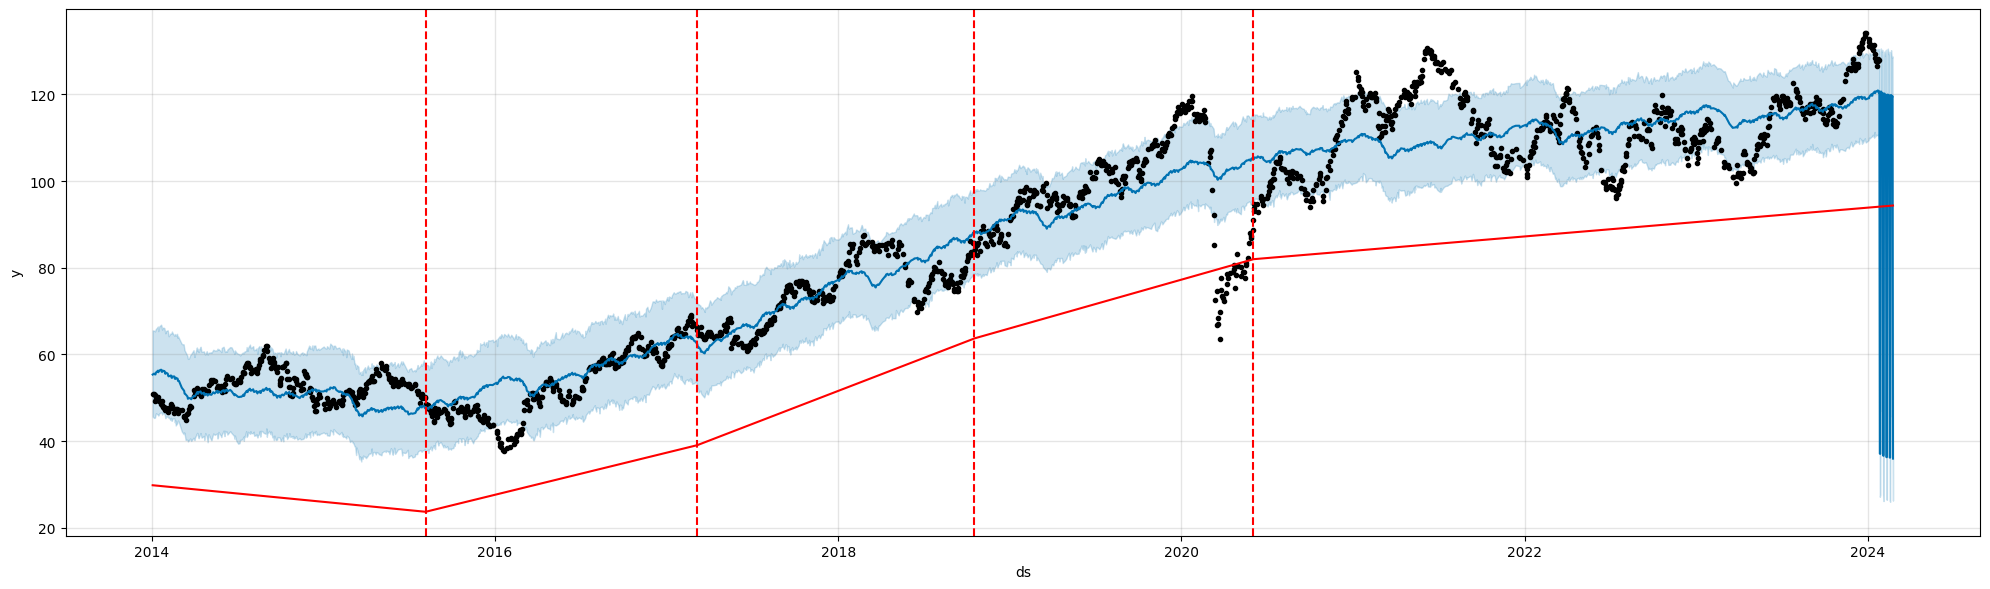

In [385]:
fig = modelo_changepoints.plot(previsao_changepoints, figsize=(20,6));
a = add_changepoints_to_plot(fig.gca(), modelo_changepoints, previsao_changepoints)

In [386]:
# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 5.54%


**OBS: Olha como melhorou o nosso MAPE geral, quando comparado ao MAPE do ARIMA**

### Cross validation
Para concluir o modelo do Prophet, tentei fazer a validação cruzada para testar dados que nunca foram vistos pelo modelo antes.

Observe que no resultado da validação cruzada temos os valores de yhat, yhat_lower, yhat_upper e o ponto de corte. O objetivo da validação cruzada é medir o erro de predição, selecionando assim pontos de corte e para cada um desses pontos o modelo é ajustado utilizando dados apenas até aquele ponto de corte.

In [387]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

INFO:prophet:Making 15 forecasts with cutoffs between 2016-03-02 00:00:00 and 2023-01-25 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/t6llagg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/eatcjuvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94514', 'data', 'file=/tmp/tmp0tzhhzdd/t6llagg0.json', 'init=/tmp/tmp0tzhhzdd/eatcjuvf.json', 'output', 'file=/tmp/tmp0tzhhzdd/prophet_modele_vd021h/prophet_model-20240128153434.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/4xgbzo_x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0tzhhzdd/j3kr2w5t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [388]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-03-03,41.371163,39.743301,43.043093,47.193,2016-03-02
1,2016-03-04,41.283888,39.764093,42.850584,49.085,2016-03-02
2,2016-03-07,41.022232,39.434454,42.491212,49.246,2016-03-02
3,2016-03-08,40.898181,39.237817,42.409117,49.102,2016-03-02
4,2016-03-09,40.906347,39.327948,42.525317,48.665,2016-03-02


In [389]:
df_cv['cutoff'].unique()

array(['2016-03-02T00:00:00.000000000', '2016-08-29T00:00:00.000000000',
       '2017-02-25T00:00:00.000000000', '2017-08-24T00:00:00.000000000',
       '2018-02-20T00:00:00.000000000', '2018-08-19T00:00:00.000000000',
       '2019-02-15T00:00:00.000000000', '2019-08-14T00:00:00.000000000',
       '2020-02-10T00:00:00.000000000', '2020-08-08T00:00:00.000000000',
       '2021-02-04T00:00:00.000000000', '2021-08-03T00:00:00.000000000',
       '2022-01-30T00:00:00.000000000', '2022-07-29T00:00:00.000000000',
       '2023-01-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [390]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,67.656730,8.225371,6.066733,0.072883,0.061505,0.072117,0.411822
1,37 days,78.061737,8.835255,6.253157,0.075739,0.062726,0.073976,0.410853
2,38 days,88.271387,9.395285,6.465356,0.078724,0.063502,0.076162,0.408269
3,39 days,99.725312,9.986256,6.714927,0.082512,0.065298,0.079140,0.399225
4,40 days,100.603353,10.030122,6.762853,0.083270,0.066009,0.079875,0.396641
...,...,...,...,...,...,...,...,...
325,361 days,397.561200,19.938937,17.364606,0.171994,0.151709,0.172582,0.390181
326,362 days,395.417565,19.885109,17.313983,0.171056,0.151709,0.171492,0.390019
327,363 days,398.883992,19.972080,17.394474,0.171327,0.153825,0.171376,0.389050
328,364 days,393.507288,19.837018,17.244232,0.170291,0.150336,0.170747,0.394057


## Tabela final com os valores de previsão dos próximos 30 dias, com PROPHET

Em resumo, o PROPHET foi o modelo com o melhor resultado, então abaixo está uma tabela com os valores que ele preveu. Com um MAPE de 5.54%

In [391]:
import pandas as pd

# Gerar datas para os próximos 90 dias
data_futuro = pd.date_range(start=df['ds'].max(), periods=30, freq='D')[1:]
data_futuro = pd.DataFrame(data_futuro, columns=['ds'])

# Fazer previsões para os próximos 90 dias
previsao_futuro = modelo.predict(data_futuro)

# Selecionar as colunas relevantes
tabela_previsao = previsao_futuro[['ds', 'yhat']].rename(columns={'yhat': 'previsao'})

# Exibir a tabela
print(tabela_previsao)

           ds    previsao
0  2024-01-26  122.889859
1  2024-01-27  123.020340
2  2024-01-28  123.006634
3  2024-01-29  122.869996
4  2024-01-30  122.833680
5  2024-01-31  122.694742
6  2024-02-01  122.472083
7  2024-02-02  122.767720
8  2024-02-03  122.887184
9  2024-02-04  122.867187
10 2024-02-05  122.728410
11 2024-02-06  122.693399
12 2024-02-07  122.558383
13 2024-02-08  122.341340
14 2024-02-09  122.643287
15 2024-02-10  122.768710
16 2024-02-11  122.753251
17 2024-02-12  122.616533
18 2024-02-13  122.580078
19 2024-02-14  122.439157
20 2024-02-15  122.210883
21 2024-02-16  122.495529
22 2024-02-17  122.596976
23 2024-02-18  122.550432
24 2024-02-19  122.375261
25 2024-02-20  122.292922
26 2024-02-21  122.098827
27 2024-02-22  121.810436
28 2024-02-23  122.028576
